## IMPORT PRE-PROCESSED DATA & SUBSET

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('NSDUH PROCESSED2.csv')

C:\Users\david\AppData\Local\Temp\ipykernel_24056\2478691757.py:1: DtypeWarning: Columns (4,7,10,22,25,34,37,38,39,41,42,43,45,46,47,49,50,51,57,58,59,61,62,63,64,66,67,68,69,70,85,87,89,90,92,93,110,113,118,119,120,137,150) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('NSDUH PROCESSED2.csv')


In [4]:
df = df.applymap(str)

In [5]:
for cols in df.columns:
    mask = (df[cols] == 'nan')
    
    df.loc[mask, cols] = np.nan

In [6]:
#check number of columns with missing data
len(df.columns[df.isnull().any()])

129

In [7]:
df.head()

,CIGEVER,CIGTRY,CIGREC,CIGAGE,CIGAREVR,CIGARTRY,CIGARREC,SMKLSSEVR,SMKLSSTRY,SMKLSSREC,...,CHAMPUS,PRVHLTIN,CELLWRKNG,GOVTPROG,INCOME,PDEN10,COUTYP4,MAIIN102,AIIND102,METHAMEVR
0,1,less than 18,1,18 or older,1,18 or older,4,1,less than 18,1,...,2,1,1,0,4,3,3,0,0,0
1,1,less than 18,1,18 or older,2,0,0,1,less than 18,4,...,2,1,1,0,3,2,2,0,0,0
2,0,0,0,0,2,0,0,2,0,0,...,2,1,1,0,2,1,1,0,0,0
3,0,0,0,0,2,0,0,2,0,0,...,2,1,1,0,4,1,1,0,0,0
4,0,0,0,0,2,0,0,2,0,0,...,2,1,1,0,2,2,2,0,0,0


In [8]:
df = df.dropna()

In [9]:
#check number of columns with missing data
len(df.columns[df.isnull().any()])

0

In [10]:
df_backup = df.copy()

In [11]:
# df = df_backup.copy()

In [12]:
df['METHAMEVR'].value_counts()

0    22306
1     1148
Name: METHAMEVR, dtype: int64

In [13]:
df['COCAGE'].value_counts()

0               20146
18 or older      2655
less than 18      650
unknown             3
Name: COCAGE, dtype: int64

# PYCARET MODELING

In [14]:
from pycaret.classification import *

In [15]:
from imblearn.under_sampling import *
from imblearn.over_sampling import *
oversample = RandomOverSampler(sampling_strategy='minority', random_state=123)
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=123)
SMOTE = SMOTE(sampling_strategy='minority', random_state=123)

## SMOTE sampling

In [16]:
s = setup(df, target = 'METHAMEVR',  session_id=123, silent=True, fix_imbalance=True, 
          fix_imbalance_method=SMOTE,
          imputation_type = 'iterative', categorical_iterative_imputer='knn')

,Description,Value
0,session_id,123
1,Target,METHAMEVR
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(23454, 158)"
5,Missing Values,0
6,Numeric Features,0
7,Categorical Features,157
8,Ordinal Features,0
9,High Cardinality Features,0


In [17]:
from sklearn.metrics import average_precision_score
add_metric('apc', 'APC', average_precision_score, target = 'pred_proba')

Name                                                               APC
Display Name                                                       APC
Score Function       <function average_precision_score at 0x0000015...
Scorer               make_scorer(average_precision_score, needs_pro...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: apc, dtype: object

In [18]:
#due to imbalance learning problem, our chosen metric for comparison is the F1-score
best = compare_models(sort='APC', n_select=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC,TT (Sec)
catboost,CatBoost Classifier,0.9605,0.9457,0.3893,0.6464,0.4829,0.4637,0.4814,0.5587,20.9740
gbc,Gradient Boosting Classifier,0.9594,0.9477,0.4574,0.6011,0.5167,0.4959,0.5024,0.5575,5.5560
lightgbm,Light Gradient Boosting Machine,0.9589,0.9461,0.3753,0.6175,0.4646,0.4446,0.4607,0.5478,1.1170
et,Extra Trees Classifier,0.9591,0.9450,0.4137,0.6037,0.4893,0.4688,0.4788,0.5410,1.4170
rf,Random Forest Classifier,0.9589,0.9449,0.3098,0.6443,0.4162,0.3977,0.4275,0.5400,0.9310
ada,Ada Boost Classifier,0.9535,0.9405,0.5037,0.5164,0.5075,0.4832,0.4845,0.5231,1.3250
xgboost,Extreme Gradient Boosting,0.9581,0.9343,0.3688,0.5988,0.4545,0.4340,0.4488,0.5195,7.1810
lr,Logistic Regression,0.8950,0.9174,0.7660,0.2790,0.4089,0.3648,0.4215,0.4655,7.7960
lda,Linear Discriminant Analysis,0.8916,0.9198,0.8008,0.2773,0.4119,0.3674,0.4308,0.4512,1.3110
knn,K Neighbors Classifier,0.7830,0.8893,0.8971,0.1672,0.2817,0.2194,0.3291,0.2338,13.8360


In [19]:
print(best)

[GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False), AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=123), ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                   

In [20]:
evaluate_model(best[0])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

### Catboost

In [19]:
cat = create_model('catboost', return_train_score = True)

In [23]:
tuned_cat, tuner = tune_model(cat, optimize='F1', return_tuner=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9464,0.9436,0.5641,0.4490,0.5000,0.4721,0.4755
1,0.9446,0.9320,0.5256,0.4316,0.4740,0.4450,0.4474
2,0.9397,0.9321,0.5641,0.4037,0.4706,0.4396,0.4465
3,0.9507,0.9382,0.6026,0.4845,0.5371,0.5114,0.5148
4,0.9458,0.9158,0.5897,0.4466,0.5083,0.4802,0.4854
5,0.9470,0.9474,0.5513,0.4526,0.4971,0.4694,0.4720
6,0.9610,0.9433,0.6410,0.5814,0.6098,0.5893,0.5901
7,0.9586,0.9563,0.6234,0.5517,0.5854,0.5636,0.5648
8,0.9458,0.9185,0.5065,0.4333,0.4671,0.4387,0.4402


In [ ]:
print(tuner)

In [22]:
#compare tuned model with default
print('Default: ', cat)
print('Tuned: ', tuned_cat)

Default:  <catboost.core.CatBoostClassifier object at 0x000001A0CF24DA90>
Tuned:  <catboost.core.CatBoostClassifier object at 0x000001A0CF24D370>


In [24]:
evaluate_model(tuned_cat)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

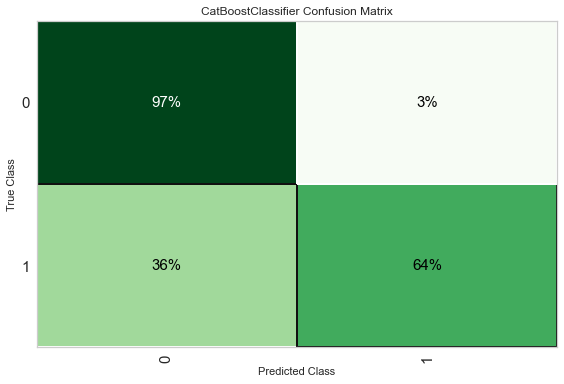

In [25]:
plot_model(tuned_cat, plot='confusion_matrix', plot_kwargs = {'percent': True})

### TOP 5 COMPARISON

In [19]:
catboost = create_model('catboost', return_train_score=True)

In [20]:
gbc = create_model('gbc', return_train_score=True)

In [21]:
lightgbm = create_model('lightgbm', return_train_score=True)

In [22]:
et = create_model('et', return_train_score=True)

In [23]:
rf = create_model('rf', return_train_score=True)

### Tune All 5

In [24]:
tuned_catboost, tuner1 = tune_model(catboost, optimize = 'APC',  return_tuner=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
Fold,,,,,,,,
0,0.9659,0.9498,0.4359,0.7391,0.5484,0.5319,0.5520,0.5978
1,0.9647,0.9393,0.4615,0.6923,0.5538,0.5362,0.5482,0.5904
2,0.9543,0.9459,0.4359,0.5231,0.4755,0.4519,0.4539,0.5043
3,0.9586,0.9603,0.3974,0.5962,0.4769,0.4563,0.4665,0.5777
4,0.9622,0.9276,0.4872,0.6333,0.5507,0.5314,0.5364,0.5268
5,0.9604,0.9481,0.4487,0.6140,0.5185,0.4984,0.5051,0.5465
6,0.9647,0.9591,0.4744,0.6852,0.5606,0.5428,0.5528,0.5917
7,0.9640,0.9641,0.3636,0.7368,0.4870,0.4705,0.5023,0.5773
8,0.9604,0.9422,0.3377,0.6500,0.4444,0.4260,0.4508,0.5267


In [25]:
tuned_gbc, tuner2 = tune_model(gbc, optimize = 'APC',  return_tuner=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
Fold,,,,,,,,
0,0.9178,0.9500,0.7564,0.3371,0.4664,0.4289,0.4703,0.5745
1,0.9166,0.9395,0.7821,0.3370,0.4710,0.4334,0.4791,0.5795
2,0.9068,0.9411,0.7692,0.3077,0.4396,0.3988,0.4490,0.4499
3,0.9281,0.9578,0.8077,0.3795,0.5164,0.4830,0.5235,0.5247
4,0.9202,0.9302,0.7949,0.3503,0.4863,0.4500,0.4948,0.4715
5,0.9147,0.9526,0.8205,0.3368,0.4776,0.4399,0.4920,0.5155
6,0.9306,0.9561,0.8462,0.3929,0.5366,0.5044,0.5481,0.5701
7,0.9311,0.9586,0.7792,0.3846,0.5150,0.4825,0.5176,0.6138
8,0.9226,0.9409,0.7662,0.3512,0.4816,0.4460,0.4859,0.5224


In [26]:
tuned_lgbm, tuner3 = tune_model(lightgbm, optimize = 'APC',  return_tuner=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
Fold,,,,,,,,
0,0.9635,0.9538,0.3974,0.7045,0.5082,0.4907,0.5126,0.6039
1,0.9647,0.9421,0.4487,0.7000,0.5469,0.5294,0.5436,0.5939
2,0.9507,0.9442,0.4231,0.4783,0.4490,0.4233,0.4241,0.4854
3,0.9610,0.9588,0.4615,0.6207,0.5294,0.5095,0.5156,0.5860
4,0.9598,0.9273,0.4487,0.6034,0.5147,0.4942,0.5001,0.5061
5,0.9574,0.9531,0.4231,0.5690,0.4853,0.4636,0.4691,0.5565
6,0.9665,0.9573,0.4872,0.7170,0.5802,0.5634,0.5748,0.5963
7,0.9653,0.9651,0.3896,0.7500,0.5128,0.4967,0.5255,0.6070
8,0.9592,0.9394,0.3766,0.6042,0.4640,0.4440,0.4574,0.5268


In [27]:
tuned_et, tuner4 = tune_model(et, optimize = 'APC',  return_tuner=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
Fold,,,,,,,,
0,0.8849,0.9515,0.8590,0.2735,0.4149,0.3694,0.4449,0.5903
1,0.8837,0.9367,0.8077,0.2636,0.3975,0.3510,0.4193,0.5899
2,0.8758,0.9406,0.8205,0.2520,0.3855,0.3374,0.4112,0.4588
3,0.8983,0.9581,0.9103,0.3074,0.4595,0.4182,0.4943,0.5737
4,0.8904,0.9308,0.8333,0.2802,0.4194,0.3749,0.4437,0.4961
5,0.8752,0.9546,0.8846,0.2604,0.4023,0.3550,0.4390,0.5674
6,0.8959,0.9537,0.8846,0.2987,0.4466,0.4043,0.4778,0.5502
7,0.8976,0.9550,0.8571,0.2960,0.4400,0.3980,0.4670,0.6269
8,0.8952,0.9412,0.8312,0.2870,0.4267,0.3837,0.4502,0.5046


In [28]:
tuned_rf, tuner5 = tune_model(rf, optimize = 'APC',  return_tuner=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
Fold,,,,,,,,
0,0.9239,0.9532,0.7949,0.3626,0.4980,0.4630,0.5050,0.5865
1,0.9202,0.9393,0.7949,0.3503,0.4863,0.4500,0.4948,0.6225
2,0.9062,0.9394,0.7821,0.3081,0.4420,0.4012,0.4536,0.4435
3,0.9227,0.9584,0.8077,0.3600,0.4980,0.4627,0.5074,0.5503
4,0.9208,0.9290,0.7949,0.3523,0.4882,0.4521,0.4964,0.4927
5,0.9178,0.9544,0.8590,0.3508,0.4981,0.4618,0.5173,0.5621
6,0.9294,0.9553,0.7949,0.3827,0.5167,0.4835,0.5214,0.5519
7,0.9330,0.9570,0.7532,0.3893,0.5133,0.4812,0.5116,0.6325
8,0.9214,0.9366,0.7273,0.3415,0.4647,0.4282,0.4641,0.5117


### Check Tuned Model Peformance on Test data

In [29]:
predict_model(tuned_catboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,CatBoost Classifier,0.9592,0.9568,0.4946,0.6466,0.5605,0.5395,0.5448,0.6353


,CIGTRY_18 or older,CIGTRY_less than 18,CIGTRY_unknown,CIGREC_1,CIGREC_2,CIGREC_3,CIGREC_4,CIGREC_others,CIGAGE_18 or older,CIGAGE_less than 18,...,PDEN10_2,PDEN10_3,COUTYP4_1,COUTYP4_2,COUTYP4_3,MAIIN102_0,AIIND102_0,METHAMEVR,Label,Score
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0.9339
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0.6152
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.9926
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.9942
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.9950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7032,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0.9194
7033,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0.9867
7034,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0.9398
7035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0.9295


In [30]:
predict_model(tuned_gbc)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Gradient Boosting Classifier,0.9204,0.9557,0.8432,0.3833,0.5270,0.4902,0.5359,0.5947


,CIGTRY_18 or older,CIGTRY_less than 18,CIGTRY_unknown,CIGREC_1,CIGREC_2,CIGREC_3,CIGREC_4,CIGREC_others,CIGAGE_18 or older,CIGAGE_less than 18,...,PDEN10_2,PDEN10_3,COUTYP4_1,COUTYP4_2,COUTYP4_3,MAIIN102_0,AIIND102_0,METHAMEVR,Label,Score
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0.5
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0.5
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.5
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.5
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7032,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0.5
7033,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0.5
7034,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0.5
7035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0.5


In [31]:
predict_model(tuned_lgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Light Gradient Boosting Machine,0.9604,0.9595,0.5027,0.6619,0.5714,0.5511,0.5568,0.6375


,CIGTRY_18 or older,CIGTRY_less than 18,CIGTRY_unknown,CIGREC_1,CIGREC_2,CIGREC_3,CIGREC_4,CIGREC_others,CIGAGE_18 or older,CIGAGE_less than 18,...,PDEN10_2,PDEN10_3,COUTYP4_1,COUTYP4_2,COUTYP4_3,MAIIN102_0,AIIND102_0,METHAMEVR,Label,Score
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0.9307
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0.6868
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.9947
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.9948
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.9974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7032,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0.9614
7033,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0.9778
7034,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0.9709
7035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0.9704


In [32]:
predict_model(tuned_et)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Extra Trees Classifier,0.8899,0.9552,0.9054,0.3116,0.4637,0.4181,0.4928,0.6038


,CIGTRY_18 or older,CIGTRY_less than 18,CIGTRY_unknown,CIGREC_1,CIGREC_2,CIGREC_3,CIGREC_4,CIGREC_others,CIGAGE_18 or older,CIGAGE_less than 18,...,PDEN10_2,PDEN10_3,COUTYP4_1,COUTYP4_2,COUTYP4_3,MAIIN102_0,AIIND102_0,METHAMEVR,Label,Score
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0.8324
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0.7316
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.7591
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.7601
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.7945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7032,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0.5822
7033,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0.6870
7034,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0.5341
7035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0.5450


In [33]:
predict_model(tuned_rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Random Forest Classifier,0.9196,0.9558,0.8405,0.3802,0.5236,0.4864,0.5324,0.6096


,CIGTRY_18 or older,CIGTRY_less than 18,CIGTRY_unknown,CIGREC_1,CIGREC_2,CIGREC_3,CIGREC_4,CIGREC_others,CIGAGE_18 or older,CIGAGE_less than 18,...,PDEN10_2,PDEN10_3,COUTYP4_1,COUTYP4_2,COUTYP4_3,MAIIN102_0,AIIND102_0,METHAMEVR,Label,Score
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0.8357
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0.7453
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.8355
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.8324
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.8930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7032,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0.6437
7033,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0.7982
7034,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0.6228
7035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0.5913


In [34]:
evaluate_model(tuned_lgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

### Random Forest

In [31]:
#Focus on Tree Based Ensembles so we can evaluate feature importance
#random forest
rf = create_model('rf', return_train_score=True)

In [27]:
print(rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


In [32]:
#tune rf
tuned_rf, tuner = tune_model(rf, optimize = 'F1',  return_tuner=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
Fold,,,,,,,,
0,0.9239,0.9532,0.7949,0.3626,0.4980,0.4630,0.5050,0.5865
1,0.9202,0.9393,0.7949,0.3503,0.4863,0.4500,0.4948,0.6225
2,0.9062,0.9394,0.7821,0.3081,0.4420,0.4012,0.4536,0.4435
3,0.9227,0.9584,0.8077,0.3600,0.4980,0.4627,0.5074,0.5503
4,0.9208,0.9290,0.7949,0.3523,0.4882,0.4521,0.4964,0.4927
5,0.9178,0.9544,0.8590,0.3508,0.4981,0.4618,0.5173,0.5621
6,0.9294,0.9553,0.7949,0.3827,0.5167,0.4835,0.5214,0.5519
7,0.9330,0.9570,0.7532,0.3893,0.5133,0.4812,0.5116,0.6325
8,0.9214,0.9366,0.7273,0.3415,0.4647,0.4282,0.4641,0.5117


In [33]:
predict_model(tuned_rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Random Forest Classifier,0.9196,0.9558,0.8405,0.3802,0.5236,0.4864,0.5324,0.6096


,CIGTRY_18 or older,CIGTRY_less than 18,CIGTRY_unknown,CIGREC_1,CIGREC_2,CIGREC_3,CIGREC_4,CIGREC_others,CIGAGE_18 or older,CIGAGE_less than 18,...,PDEN10_2,PDEN10_3,COUTYP4_1,COUTYP4_2,COUTYP4_3,MAIIN102_0,AIIND102_0,METHAMEVR,Label,Score
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0.8357
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0.7453
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.8355
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.8324
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.8930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7032,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0.6437
7033,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0.7982
7034,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0.6228
7035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0.5913


In [ ]:
print(tuner)

In [34]:
#compare tuned rf with default
print('Default: ', rf)
print('Tuned: ', tuned_rf)

Default:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)
Tuned:  RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=6, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                 

In [35]:
evaluate_model(tuned_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

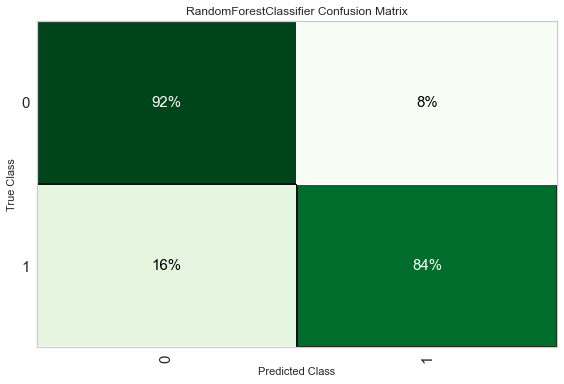

In [36]:
plot_model(tuned_rf, plot='confusion_matrix', plot_kwargs = {'percent': True})

### GBC

In [21]:
#gbc
gbc = create_model('gbc', return_train_score=True)

In [27]:
predict_model(gbc)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Gradient Boosting Classifier,0.9594,0.9575,0.5351,0.6346,0.5806,0.5595,0.5617,0.6035


,CIGTRY_18 or older,CIGTRY_less than 18,CIGTRY_unknown,CIGREC_1,CIGREC_2,CIGREC_3,CIGREC_4,CIGREC_others,CIGAGE_18 or older,CIGAGE_less than 18,...,PDEN10_2,PDEN10_3,COUTYP4_1,COUTYP4_2,COUTYP4_3,MAIIN102_0,AIIND102_0,METHAMEVR,Label,Score
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0.9235
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0.7261
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.9933
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.9931
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.9928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7032,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0.9398
7033,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0.9839
7034,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0.9632
7035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0.9401


In [22]:
#tune gbc
tuned_gbc, tuner = tune_model(gbc, optimize='F1', return_tuner=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
Fold,,,,,,,,
0,0.9507,0.9497,0.6538,0.4857,0.5574,0.5319,0.5385,0.5545
1,0.9470,0.9396,0.6923,0.4615,0.5538,0.5269,0.5391,0.5636
2,0.9275,0.9430,0.5897,0.3459,0.4360,0.4001,0.4164,0.4521
3,0.9470,0.9576,0.6410,0.4587,0.5348,0.5075,0.5155,0.5268
4,0.9464,0.9328,0.6282,0.4537,0.5269,0.4993,0.5067,0.4970
5,0.9470,0.9518,0.6795,0.4609,0.5492,0.5222,0.5333,0.4891
6,0.9543,0.9567,0.6410,0.5155,0.5714,0.5476,0.5512,0.5835
7,0.9580,0.9630,0.6234,0.5455,0.5818,0.5598,0.5612,0.6131
8,0.9445,0.9396,0.5455,0.4286,0.4800,0.4512,0.4548,0.5114


In [25]:
predict_model(tuned_gbc)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Gradient Boosting Classifier,0.9480,0.9571,0.7405,0.5037,0.5996,0.5728,0.5850,0.6013


,CIGTRY_18 or older,CIGTRY_less than 18,CIGTRY_unknown,CIGREC_1,CIGREC_2,CIGREC_3,CIGREC_4,CIGREC_others,CIGAGE_18 or older,CIGAGE_less than 18,...,PDEN10_2,PDEN10_3,COUTYP4_1,COUTYP4_2,COUTYP4_3,MAIIN102_0,AIIND102_0,METHAMEVR,Label,Score
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0.5053
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0.5028
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.5085
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.5082
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.5087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7032,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0.5048
7033,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0.5074
7034,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0.5035
7035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0.5045


In [24]:
#tune gbc
tuned_gbc2, tuner = tune_model(gbc, optimize='APC', return_tuner=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
Fold,,,,,,,,
0,0.9178,0.9500,0.7564,0.3371,0.4664,0.4289,0.4703,0.5745
1,0.9166,0.9395,0.7821,0.3370,0.4710,0.4334,0.4791,0.5795
2,0.9068,0.9411,0.7692,0.3077,0.4396,0.3988,0.4490,0.4499
3,0.9281,0.9578,0.8077,0.3795,0.5164,0.4830,0.5235,0.5247
4,0.9202,0.9302,0.7949,0.3503,0.4863,0.4500,0.4948,0.4715
5,0.9147,0.9526,0.8205,0.3368,0.4776,0.4399,0.4920,0.5155
6,0.9306,0.9561,0.8462,0.3929,0.5366,0.5044,0.5481,0.5701
7,0.9311,0.9586,0.7792,0.3846,0.5150,0.4825,0.5176,0.6138
8,0.9226,0.9409,0.7662,0.3512,0.4816,0.4460,0.4859,0.5224


In [26]:
predict_model(tuned_gbc2)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Gradient Boosting Classifier,0.9204,0.9557,0.8432,0.3833,0.5270,0.4902,0.5359,0.5947


,CIGTRY_18 or older,CIGTRY_less than 18,CIGTRY_unknown,CIGREC_1,CIGREC_2,CIGREC_3,CIGREC_4,CIGREC_others,CIGAGE_18 or older,CIGAGE_less than 18,...,PDEN10_2,PDEN10_3,COUTYP4_1,COUTYP4_2,COUTYP4_3,MAIIN102_0,AIIND102_0,METHAMEVR,Label,Score
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0.5
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0.5
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.5
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.5
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7032,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0.5
7033,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0.5
7034,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0.5
7035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0.5


In [ ]:
print(tuner)

In [23]:
predict_model(gbc)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Gradient Boosting Classifier,0.9594,0.9575,0.5351,0.6346,0.5806,0.5595,0.5617,0.6035


,CIGTRY_18 or older,CIGTRY_less than 18,CIGTRY_unknown,CIGREC_1,CIGREC_2,CIGREC_3,CIGREC_4,CIGREC_others,CIGAGE_18 or older,CIGAGE_less than 18,...,PDEN10_2,PDEN10_3,COUTYP4_1,COUTYP4_2,COUTYP4_3,MAIIN102_0,AIIND102_0,METHAMEVR,Label,Score
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0.9235
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0.7261
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.9933
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.9931
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.9928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7032,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0.9398
7033,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0.9839
7034,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0.9632
7035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0.9401


In [43]:
#compare tuned model with default
print(gbc)
print(tuned_gbc)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=1e-07, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.02, min_impurity_split=None

In [30]:
evaluate_model(tuned_gbc)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

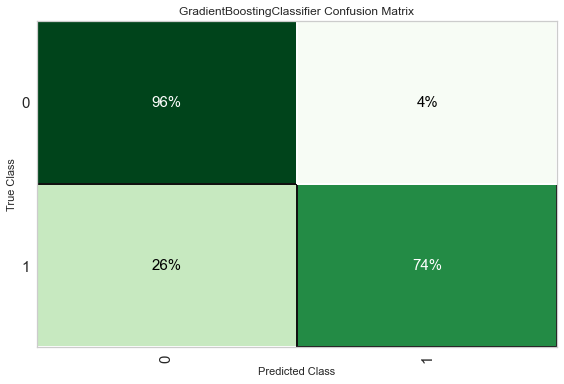

In [29]:
plot_model(tuned_gbc, plot='confusion_matrix', plot_kwargs = {'percent': True})

### Adaboost

In [71]:
#adaboost
ada = create_model('ada', return_train_score=True)

In [72]:
#tune catboost
tuned_ada, tuner = tune_model(ada, optimize='F1', return_tuner=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8861,0.9469,0.8590,0.2757,0.4174,0.3723,0.4471
1,0.8916,0.9417,0.8077,0.2788,0.4145,0.3700,0.4343
2,0.8831,0.9434,0.8462,0.2683,0.4074,0.3613,0.4357
3,0.9019,0.9586,0.8718,0.3105,0.4579,0.4171,0.4850
4,0.8971,0.9253,0.7949,0.2884,0.4232,0.3800,0.4395
5,0.8879,0.9529,0.8846,0.2828,0.4286,0.3842,0.4621
6,0.9001,0.9531,0.8718,0.3063,0.4533,0.4120,0.4811
7,0.9037,0.9585,0.8831,0.3134,0.4626,0.4226,0.4918
8,0.9013,0.9404,0.8052,0.2967,0.4336,0.3919,0.4511


In [73]:
print(tuner)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('fix_imbalance',
                                              RandomUnderSampler(random_state=123,
                                                                 replacement=False,
                                                                 sampling_strategy='majority')),
                                             ('actual_estimator',
                                              AdaBoostClassifier(algorithm='SAMME.R',
                                                                 base_estimator=None,
                                                                 learning_rate=1.0,
                                                                 n_estimators=5...
                                                                            1e-06,
            

In [74]:
#compare tuned model with default
print(ada)
print(tuned_ada)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=123)
AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=0.2,
                   n_estimators=230, random_state=123)


In [75]:
evaluate_model(tuned_ada)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…